# Measure Disease associations Gene Edge Recall

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import math
from pathlib import Path

import numpy as np
import pandas as pd
import plotnine as p9
import plydata as ply
import plydata.tidy as ply_tdy
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sqlalchemy import create_engine

In [2]:
# Set up the environment
username = "danich1"
password = "snorkel"
dbname = "pubmed_central_db"

# Path subject to change for different os
database_str = (
    f"postgresql+psycopg2://{username}:{password}@/{dbname}?host=/var/run/postgresql"
)
conn = create_engine(database_str)

In [3]:
hetionet_cbg_map_df = pd.read_csv(
    Path("../snorkeling_helper/label_functions/knowledge_bases")
    / "compound_binds_gene.tsv.xz",
    sep="\t",
)
hetionet_cbg_map_df >> ply.slice_rows(5)

,entrez_gene_id,gene_symbol,drugbank_id,name,sources,hetionet,n_sentences,has_sentence,partition_rank,split
0,1,A1BG,DB00117,L-Histidine,NaN,0,1,1,0.37753,6
1,1,A1BG,DB00143,Glutathione,NaN,0,1,1,0.30352,6
2,1,A1BG,DB00145,Glycine,NaN,0,1,1,0.10286,6
3,1,A1BG,DB00162,Vitamin A,NaN,0,2,1,0.63714,6
4,1,A1BG,DB00346,Alfuzosin,NaN,0,1,1,0.24998,6


In [4]:
sentence_prediction_df = pd.read_csv(
    "output/all_predicted_cbg_sentences.tsv", sep="\t"
) >> ply.arrange("candidate_id")
sentence_prediction_df >> ply.slice_rows(5)

,pred,candidate_id
0,0.107848,186
1,0.044049,191
2,0.027554,277
3,0.023069,279
4,0.032638,281


In [5]:
sql = """
select candidate_id, compound_cid as drugbank_id, gene_cid as entrez_gene_id
from compound_gene inner join (
    select sentence_id, document_id
    from sentence
) as sentence_map
on compound_gene.sentence_id = sentence_map.sentence_id
where section = 'title' or section ='abstract'
"""
candidate_to_sentence_map_df = (
    pd.read_sql(sql, conn)
    >> ply_tdy.separate_rows("entrez_gene_id", sep=";")
    >> ply.call(".astype", {"entrez_gene_id": int})
)
candidate_to_sentence_map_df >> ply.slice_rows(5)

,candidate_id,drugbank_id,entrez_gene_id
0,186,DB09256,4956
1,191,DB09341,173
2,277,DB09341,173
3,279,DB09341,478
4,281,DB09341,496


# Merge Predictions with Candidates and Hetionet Map

In [6]:
all_cbg_predictions_df = (
    sentence_prediction_df
    >> ply.inner_join(candidate_to_sentence_map_df, on="candidate_id")
    >> ply.inner_join(
        hetionet_cbg_map_df >> ply.select("-sources", "-n_sentences"),
        on=["entrez_gene_id", "drugbank_id"],
    )
)
all_cbg_predictions_df >> ply.slice_rows(5)

,pred,candidate_id,drugbank_id,entrez_gene_id,gene_symbol,name,hetionet,has_sentence,partition_rank,split
0,0.102639,405,DB00035,79674,VEPH1,Desmopressin,0,1,0.98929,8
1,0.124693,407,DB00035,79674,VEPH1,Desmopressin,0,1,0.98929,8
2,0.029781,18039277,DB00035,79674,VEPH1,Desmopressin,0,1,0.98929,8
3,0.114405,449,DB00815,7450,VWF,Sodium lauryl sulfate,0,1,0.83554,7
4,0.127427,450,DB00815,7450,VWF,Sodium lauryl sulfate,0,1,0.83554,7


In [7]:
all_cbg_df = (
    all_cbg_predictions_df
    >> ply.group_by("entrez_gene_id", "drugbank_id")
    >> ply.define(
        pred_max="max(pred)", pred_mean="mean(pred)", pred_median="median(pred)"
    )
    >> ply.select("-pred", "-candidate_id")
    >> ply.distinct()
    >> ply.ungroup()
    >> ply_tdy.gather("metric", "score", ["pred_max", "pred_mean", "pred_median"])
)
all_cbg_df >> ply.slice_rows(10)

,drugbank_id,entrez_gene_id,gene_symbol,name,hetionet,has_sentence,partition_rank,split,metric,score
0,DB00035,79674,VEPH1,Desmopressin,0,1,0.98929,8,pred_max,0.124693
1,DB00815,7450,VWF,Sodium lauryl sulfate,0,1,0.83554,7,pred_max,0.237307
2,DB00808,1636,ACE,Indapamide,0,1,0.33349,6,pred_max,0.242156
3,DB01065,5578,PRKCA,Melatonin,0,1,0.22071,6,pred_max,0.258310
4,DB02556,183,AGT,D-Phenylalanine,0,1,0.10776,6,pred_max,0.552032
5,DB01164,240,ALOX5,Calcium Chloride,0,1,0.82966,7,pred_max,0.376059
6,DB04557,240,ALOX5,Arachidonic Acid,0,1,0.82308,7,pred_max,0.327458
7,DB02032,1636,ACE,1-(3-Mercapto-2-Methyl-Propionyl)-Pyrrolidine-...,1,1,0.83693,7,pred_max,0.603183
8,DB02853,1636,ACE,D-Proline,0,1,0.38897,6,pred_max,0.369924
9,DB02853,3827,KNG1,D-Proline,0,1,0.27077,6,pred_max,0.346249


In [8]:
test_entity_df = all_cbg_df >> ply.query("split == 7")
test_entity_df >> ply.slice_rows(5)

,drugbank_id,entrez_gene_id,gene_symbol,name,hetionet,has_sentence,partition_rank,split,metric,score
1,DB00815,7450,VWF,Sodium lauryl sulfate,0,1,0.83554,7,pred_max,0.237307
5,DB01164,240,ALOX5,Calcium Chloride,0,1,0.82966,7,pred_max,0.376059
6,DB04557,240,ALOX5,Arachidonic Acid,0,1,0.82308,7,pred_max,0.327458
7,DB02032,1636,ACE,1-(3-Mercapto-2-Methyl-Propionyl)-Pyrrolidine-...,1,1,0.83693,7,pred_max,0.603183
11,DB00107,8833,GMPS,Oxytocin,0,1,0.82302,7,pred_max,0.079604


# Determine Precision and Recall

In [9]:
performance_map = dict()

In [10]:
precision, recall, pr_threshold = precision_recall_curve(
    test_entity_df >> ply.query("metric=='pred_max'") >> ply.pull("hetionet"),
    test_entity_df >> ply.query("metric=='pred_max'") >> ply.pull("score"),
)

fpr, tpr, roc_threshold = roc_curve(
    test_entity_df >> ply.query("metric=='pred_max'") >> ply.pull("hetionet"),
    test_entity_df >> ply.query("metric=='pred_max'") >> ply.pull("score"),
)

performance_map["PR"] = (
    pd.DataFrame(
        {
            "precision": precision,
            "recall": recall,
            "pr_threshold": np.append(pr_threshold, 1),
        }
    )
    >> ply.define(model=f'"pred_max/AUC={auc(recall, precision):.2f}"')
)

performance_map["AUROC"] = pd.DataFrame(
    {"fpr": fpr, "tpr": tpr, "roc_threshold": roc_threshold}
) >> ply.define(model=f'"pred_max/AUC={auc(fpr, tpr):.2f}"')

In [11]:
precision, recall, pr_threshold = precision_recall_curve(
    test_entity_df >> ply.query("metric=='pred_mean'") >> ply.pull("hetionet"),
    test_entity_df >> ply.query("metric=='pred_mean'") >> ply.pull("score"),
)

fpr, tpr, roc_threshold = roc_curve(
    test_entity_df >> ply.query("metric=='pred_mean'") >> ply.pull("hetionet"),
    test_entity_df >> ply.query("metric=='pred_mean'") >> ply.pull("score"),
)

performance_map["PR"] = performance_map["PR"].append(
    pd.DataFrame(
        {
            "precision": precision,
            "recall": recall,
            "pr_threshold": np.append(pr_threshold, 1),
        }
    )
    >> ply.define(model=f'"pred_mean/AUC={auc(recall, precision):.2f}"')
)

performance_map["AUROC"] = performance_map["AUROC"].append(
    pd.DataFrame({"fpr": fpr, "tpr": tpr, "roc_threshold": roc_threshold})
    >> ply.define(model=f'"pred_mean/AUC={auc(fpr, tpr):.2f}"')
)

In [12]:
precision, recall, pr_threshold = precision_recall_curve(
    test_entity_df >> ply.query("metric=='pred_median'") >> ply.pull("hetionet"),
    test_entity_df >> ply.query("metric=='pred_median'") >> ply.pull("score"),
)

fpr, tpr, roc_threshold = roc_curve(
    test_entity_df >> ply.query("metric=='pred_median'") >> ply.pull("hetionet"),
    test_entity_df >> ply.query("metric=='pred_median'") >> ply.pull("score"),
)

performance_map["PR"] = performance_map["PR"].append(
    pd.DataFrame(
        {
            "precision": precision,
            "recall": recall,
            "pr_threshold": np.append(pr_threshold, 1),
        }
    )
    >> ply.define(model=f'"pred_median/AUC={auc(recall, precision):.2f}"')
)

performance_map["AUROC"] = performance_map["AUROC"].append(
    pd.DataFrame({"fpr": fpr, "tpr": tpr, "roc_threshold": roc_threshold})
    >> ply.define(model=f'"pred_median/AUC={auc(fpr, tpr):.2f}"')
)

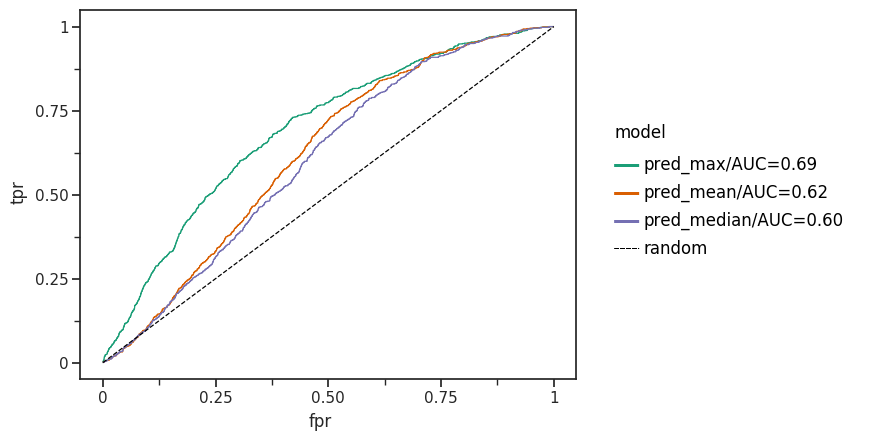

<ggplot: (8783568523675)>


In [13]:
g = (
    p9.ggplot(
        performance_map["AUROC"]
        >> ply.call(
            ".append",
            pd.DataFrame(
                {
                    "fpr": [0, 0.25, 0.5, 0.75, 1],
                    "tpr": [0, 0.25, 0.5, 0.75, 1],
                    "model": "random",
                }
            ),
        )
    )
    + p9.aes(x="fpr", y="tpr", group="model", color="model", linetype="model")
    + p9.geom_line()
    + p9.theme_seaborn("white")
    + p9.scale_color_manual(["#1b9e77", "#d95f02", "#7570b3", "#000000"])
    + p9.scale_linetype_manual(["solid", "solid", "solid", "dashed"])
)
print(g)

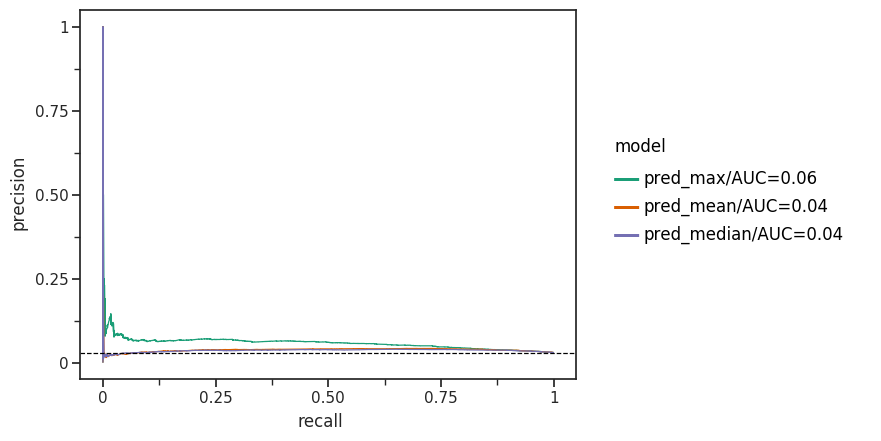

<ggplot: (8783568613489)>


In [14]:
g = (
    p9.ggplot(performance_map["PR"])
    + p9.aes(x="recall", y="precision", group="model", color="model", linetype="model")
    + p9.geom_line()
    + p9.theme_seaborn("white")
    + p9.scale_color_manual(["#1b9e77", "#d95f02", "#7570b3", "#000000"])
    + p9.scale_linetype_manual(["solid", "solid", "solid", "dashed"])
    + p9.geom_hline(
        yintercept=(
            test_entity_df >> ply.query("metric=='pred_median'") >> ply.pull("hetionet")
        ).mean(),
        linetype="dashed",
    )
)
print(g)

## Estimate number of new Edges Added

In [15]:
df_iterator = (
    performance_map["PR"]
    >> ply.query("model.str.contains('max')& pr_threshold < 1")
    >> ply.call(".round", {"pr_threshold": 2})
    >> ply.distinct("pr_threshold", "last")
)

edges_added_records = []
for idx, row in df_iterator.iterrows():
    cutoff = row["pr_threshold"]

    values_added = (
        all_cbg_df
        >> ply.query("metric.str.contains('max')")
        >> ply.query("score >= @cutoff")
        >> ply.pull("hetionet")
    )

    edges_added_records.append(
        {
            "edges": values_added.sum(),
            "in_hetionet": "Existing",
            "precision": row["precision"],
            "sen_cutoff": cutoff,
        }
    )

    edges_added_records.append(
        {
            "edges": values_added.shape[0] - values_added.sum(),
            "in_hetionet": "Novel",
            "precision": row["precision"],
            "sen_cutoff": cutoff,
        }
    )


edges_added_df = pd.DataFrame.from_records(edges_added_records)
edges_added_df >> ply.slice_rows(10)

,edges,in_hetionet,precision,sen_cutoff
0,4278,Existing,0.029812,0.02
1,138888,Novel,0.029812,0.02
2,4269,Existing,0.030355,0.03
3,136649,Novel,0.030355,0.03
4,4258,Existing,0.031060,0.04
5,132945,Novel,0.031060,0.04
6,4227,Existing,0.032036,0.05
7,128025,Novel,0.032036,0.05
8,4186,Existing,0.033277,0.06
9,122221,Novel,0.033277,0.06


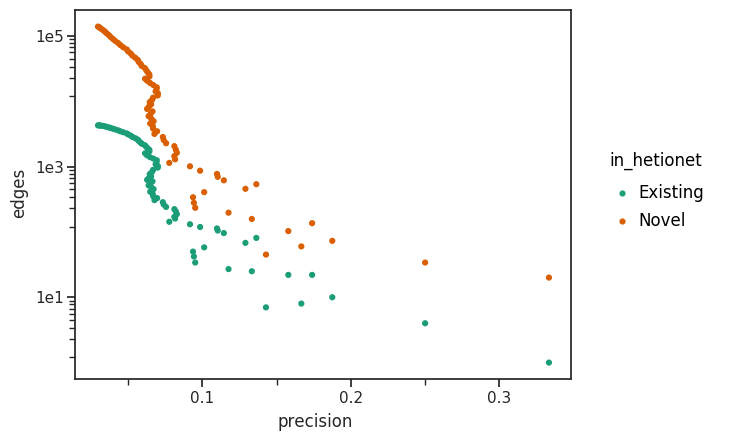

<ggplot: (8783569722067)>


In [16]:
g = (
    p9.ggplot(edges_added_df >> ply.query("edges > 0 & precision > 0"))
    + p9.aes(x="precision", y="edges", color="in_hetionet")
    + p9.geom_point()
    + p9.theme_seaborn("white")
    + p9.scale_color_brewer(type="qual", palette=2)
    + p9.scale_y_log10()
)
print(g)

In [17]:
edges_df = pd.DataFrame.from_records(
    [
        {
            "recall": (
                all_cbg_df
                >> ply.query("metric=='pred_max' & score > 0.05")
                >> ply.pull("hetionet")
            ).sum()
            / all_cbg_df.query("hetionet == 1").shape[0],
            "edges": (
                all_cbg_df
                >> ply.query("metric=='pred_max' & score > 0.05")
                >> ply.pull("hetionet")
            ).sum(),
            "in_hetionet": "Existing",
            "relation": "CbG",
        },
        {
            "edges": (
                all_cbg_df
                >> ply.query("metric=='pred_max' & score > 0.05")
                >> ply.query("hetionet==0")
            ).shape[0],
            "in_hetionet": "Novel",
            "relation": "CbG",
        },
    ]
)

edges_df

,recall,edges,in_hetionet,relation
0,0.329052,4227,Existing,CbG
1,NaN,128025,Novel,CbG


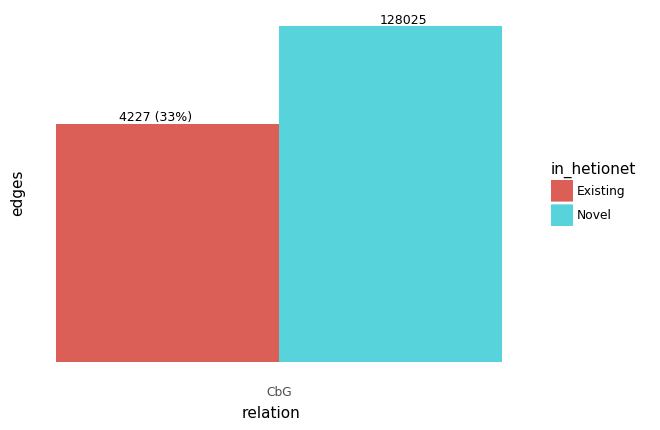

<ggplot: (-9223363253285064767)>


In [18]:
g = (
    p9.ggplot(edges_df, p9.aes(x="relation", y="edges", fill="in_hetionet"))
    + p9.geom_col(position="dodge")
    + p9.geom_text(
        p9.aes(
            label=(
                edges_df.apply(
                    lambda x: f"{x['edges']} ({x['recall']*100:.0f}%)"
                    if not math.isnan(x["recall"])
                    else f"{x['edges']}",
                    axis=1,
                )
            )
        ),
        position=p9.position_dodge(width=1),
        size=9,
        va="bottom",
    )
    + p9.scale_y_log10()
    + p9.theme(
        axis_text_y=p9.element_blank(),
        axis_ticks_major=p9.element_blank(),
        rect=p9.element_blank(),
    )
)
print(g)